In [1]:
from models.classical_sstw import ClassicalSSTWModel, train
from datasetsloader import TUMDataset
import torch
import cv2

In [2]:
dataset = TUMDataset(
  [
    "./datasets/a9_dataset_r01_s01/_new_labels",
    "./datasets/a9_dataset_r01_s02/_new_labels",
    "./datasets/a9_dataset_r01_s03/_new_labels",
  ],
  "datasets/categories/category.json",
  skip_no_features=True,
)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [237, 30, 30])

def collate_fn(batch):
  imgs, annots = zip(*batch)
  imgs = torch.stack(imgs, dim=0)
  
  batched_targets = {}
  
  for key in annots[0].keys():
    batched_targets[key] = torch.stack([a[key] for a in annots], dim=0)
  
  return imgs, batched_targets

train_loader = torch.utils.data.DataLoader(
  dataset,
  shuffle=True,
  batch_size=64,
  collate_fn=collate_fn,
)

val_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=32,
  collate_fn=collate_fn,
)

test_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=32,
  collate_fn=collate_fn,
)

In [7]:
model = ClassicalSSTWModel()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
best_model_params, cls_loss_history, reg_loss_history, loss_history, val_cls_loss_history, val_reg_loss_history, val_loss_history = train(
  model,
  train_loader,
  val_loader,
  20,
  device,
  './outputs/models',
  5,
  15,
  False,
  0.95,
)

torch.save(best_model_params, 'outputs/best_model.pth')

Epoch [1/20] - Average Validation Loss: 1.13, Average Training Loss: 2.17
Epoch [2/20] - Average Validation Loss: 0.79, Average Training Loss: 0.95
Epoch [3/20] - Average Validation Loss: 0.63, Average Training Loss: 0.73
Epoch [4/20] - Average Validation Loss: 0.42, Average Training Loss: 0.55
Epoch [5/20] - Average Validation Loss: 0.29, Average Training Loss: 0.35
Epoch [6/20] - Average Validation Loss: 0.24, Average Training Loss: 0.26
Epoch [7/20] - Average Validation Loss: 0.21, Average Training Loss: 0.22
Epoch [8/20] - Average Validation Loss: 0.18, Average Training Loss: 0.19
Epoch [9/20] - Average Validation Loss: 0.17, Average Training Loss: 0.17
Epoch [10/20] - Average Validation Loss: 0.16, Average Training Loss: 0.16
Epoch [11/20] - Average Validation Loss: 0.15, Average Training Loss: 0.15
Epoch [12/20] - Average Validation Loss: 0.14, Average Training Loss: 0.13
Epoch [13/20] - Average Validation Loss: 0.12, Average Training Loss: 0.12
Epoch [14/20] - Average Validation

In [ ]:
category_count = [0] * 7

for x, y in train_loader:
  for label_id in y['labels']:
    for label in label_id:
      category_count[label - 1] += 1

print(category_count)

[538, 1436, 500, 441, 21, 3, 35077]


In [3]:
best_model = ClassicalSSTWModel()
best_model.eval()

best_model.load_state_dict(torch.load('outputs/best_model.pth'))

<All keys matched successfully>

In [ ]:
def apply_box_deltas(proposals, deltas):
    # proposals: [N, 4] (x1, y1, x2, y2)
    # deltas:    [N, 4] (tx, ty, tw, th)
    
    # 1. Convert Proposals to Center-Width-Height (x, y, w, h)
    p_width  = proposals[:, 2] - proposals[:, 0]
    p_height = proposals[:, 3] - proposals[:, 1]
    p_ctr_x  = proposals[:, 0] + 0.5 * p_width
    p_ctr_y  = proposals[:, 1] + 0.5 * p_height

    # 2. Extract Deltas
    dx = deltas[:, 0]
    dy = deltas[:, 1]
    dw = deltas[:, 2].clamp(min=-1.0, max=1.0) 
    dh = deltas[:, 3].clamp(min=-1.0, max=1.0)
    
    pred_w = p_width * torch.exp(dw)
    pred_h = p_height * torch.exp(dh)

    # 3. Apply Adjustments (R-CNN Paper Math)
    # New Center = Old Center + (Width * Delta)
    pred_ctr_x = p_ctr_x + p_width * dx
    pred_ctr_y = p_ctr_y + p_height * dy
    
    pred_w     = p_width * torch.exp(dw)
    pred_h     = p_height * torch.exp(dh)

    pred_x1 = pred_ctr_x - 0.5 * pred_w
    pred_y1 = pred_ctr_y - 0.5 * pred_h
    pred_x2 = pred_ctr_x + 0.5 * pred_w
    pred_y2 = pred_ctr_y + 0.5 * pred_h

    pred_boxes = torch.stack([pred_x1, pred_y1, pred_x2, pred_y2], dim=1)
    
    pred_boxes[:, 0::2] = pred_boxes[:, 0::2].clamp(min=0, max=800) 
    pred_boxes[:, 1::2] = pred_boxes[:, 1::2].clamp(min=0, max=800)

    return pred_boxes

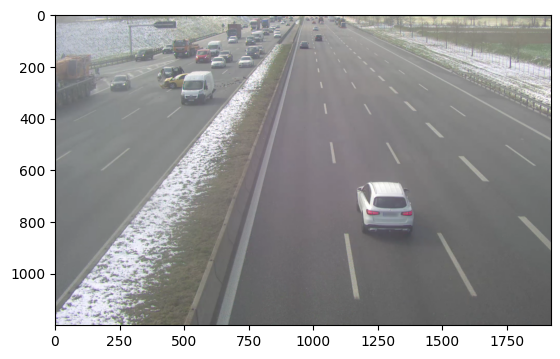

In [30]:
for x, y in train_loader:
  plt.imshow(x[0].permute(1, 2, 0))
  sample_image = x[0]
  break

In [33]:
import torchvision
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

img_display = sample_image.cpu().permute(1, 2, 0).numpy()
img_display = (img_display).astype(np.uint8).copy()

best_model.eval()
with torch.no_grad():
    proposals, labels, scores, deltas = best_model(img_display, None, training=False)

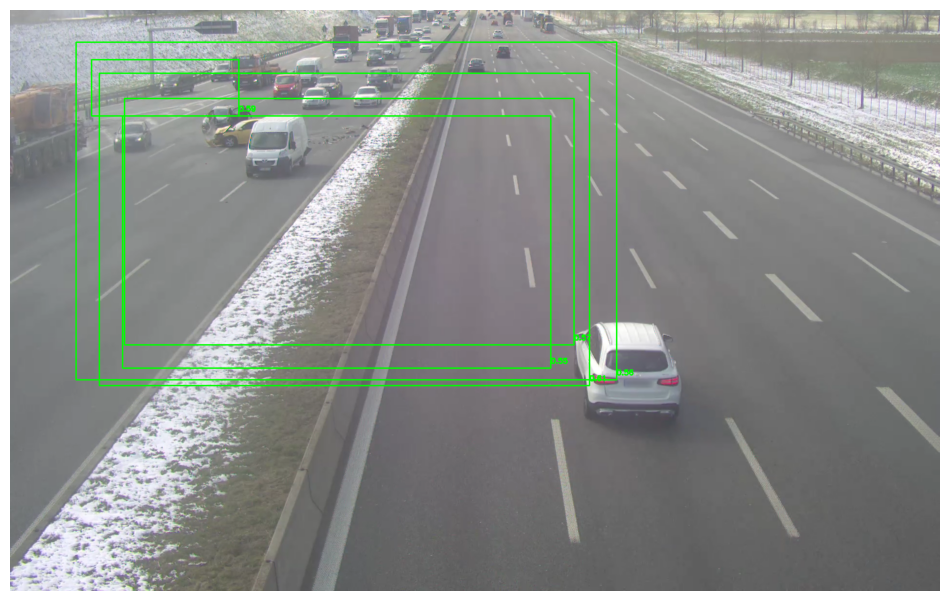

In [34]:
if len(proposals) > 0:
    refined_boxes = apply_box_deltas(proposals, deltas)
else:
    refined_boxes = proposals
    
keep_indices = torchvision.ops.nms(refined_boxes, scores, iou_threshold=0.3)

final_boxes_clean = refined_boxes[keep_indices].cpu().numpy().astype(int)
final_scores_clean = scores[keep_indices].cpu().numpy()

for i, box in enumerate(final_boxes_clean):
    if final_scores_clean[i] > 0.5: 
        x1, y1, x2, y2 = box
        
        x1 *= 4
        y1 *= 4
        x2 *= 4
        y2 *= 4
        
        # Draw Box (Green)
        cv2.rectangle(img_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Draw Score
        text = f"{final_scores_clean[i]:.2f}"
        cv2.putText(img_display, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(img_display)
plt.axis('off')
plt.show()